# City-scale car traffic and parking density maps from Uber Movement travel time data

---

##  Overview

1. Introduction
2. Data preparation
3. Stochastic distributions
4. Sampling
5. Model selection

---

## 1 Introduction

Car parking is of central importance to congestion on roads and the urban planning process of optimizing road networks, pricing parking lots and planning land use. The efficient placement, sizing and grid connection of charging stations for electric cars makes it even more important to know the spatio-temporal distribution of car parking densities on the scale of entire cities. It is currently difficult and expensive to measure such data directly. Here, we generate car parking density maps for 33 cities worldwide using Uber travel time data only. We formulate a Hidden Markov Model that contains non-linear functional relationships between the changing average travel times among the zones of a city and both the traffic activity and flow direction probabilities of cars. We then sample the traffic flow for 1,000 cars per city zone for each city from these probability distributions and normalize the resulting spatial parking distribution of cars in each time step. Our model reaches about 90% accuracy for parking densities and up to 99% for circadian traffic activity.

We are given the arithmetic mean of hourly travel time measurements between different zones of a city and want to estimate the traffic flow and spatial parking distribution of cars in that city. We start with preparing the original data sets that we retrieve from Uber (2. Data preparation). In a first stage of our analysis, we estimate the probabilities of car traffic between zones as a function of mean travel times. These probabilities exploit the changes in mean travel time between the zones of the city throughout a day to approximate information about a) when cars would drive and b) where they would drive to (3. Stochastic distributions). In a second stage, we sample individual car traffic flows from these probability distributions and determine the number of cars parked in every zone (4. Sampling). In a third and last stage, we use actually measured parking densities and traffic activities to improve our model parameters (5. Model selection). The travel time data is provided by the Uber Movement project and is publicly accessible at https://movement.uber.com/?lang=en-US. The measurements that we use for validation and model selection are provided by the city of Melbourne and are also publicly accessible at https://data.melbourne.vic.gov.au/. The generated car parking density maps can be downloaded at https://doi.org/10.7910/DVN/8HAJFE. For citations, please use:
**Aryandoust A., van Vliet O. & Patt A. City-scale car traffic and parking density maps from Uber Movement travel time data, Scientific Data (2019).**

<img src="MethodFigure.png">

We start with importing a number of packages that we want to use throughout this notebook session. 

In [1]:
#using Pkg         
#Pkg.update()
#Pkg.add("Plots")
#Pkg.add("CSV")
#Pkg.add("Distributions")
#Pkg.add("JSON")
using Plots, CSV, Distributions, JSON, JLD2, FileIO

---

## 2. Data preparation 
In this section, we create two matrices called **"distance_matrix_km"** and **"data_matrix"** from the original Uber Movement datasets. The distance_matrix_km contains the average beeline distance between every two zones of the city in kilometers (km). The data_matrix contains the mean travel times from origin zones to destination zones and their standard deviations measured during a particular quarter of the year for each hour of the day. It has sparsity wherever the number of undertaken Uber rides were zero or not large enough to represent overall traffic.

### 2.1  Importing geographic data from a GeoJSON file (Example: Melbourne)
Each zone of the city is given as a polygon with multiple pairs of latitudinal and longitudinal coordinates. The data of these vertices is given as a JSON file. We import the JSON file and save the coordinates of each zone of the city separately in two matrices called **"longitude_matrix"** and **"latitude_matrix"**. The coordinates for each polygon are nested and unregularly split at different branches of the file. Extracting the data therefore requires a slightly more sophisticated code than in the case of an unsplit or regularly branched JSON file. 

In [2]:
path_to_json_data = "/Users/undisputed/Documents/data/Uber Movement/Melbourne/melbourne_tz.json";

import JSON
open(path_to_json_data, "r") do json_file 
    global julia_file
    julia_file = JSON.parse(json_file);
end

a = julia_file["features"];
first_zone_id = parse(Int,a[1]["properties"]["MOVEMENT_ID"]);
if (first_zone_id == 0) # catches the case that the first zone ID is a zero
    number_zones = parse(Int,a[length(a)]["properties"]["MOVEMENT_ID"]) + 1;
else
    number_zones =  parse(Int,a[length(a)]["properties"]["MOVEMENT_ID"]);
end
longitude_matrix = zeros(number_zones, 10000); 
latitude_matrix = zeros(number_zones, 10000);

for i=1:length(a)
    entry = a[i];
    id = parse(Int,entry["properties"]["MOVEMENT_ID"]);
    if (id == 0) # catches the case that the first zone ID is a zero
        id = number_zones;
    end
    coordinates = entry["geometry"]["coordinates"];
    counter = 0;
    
    if(typeof(coordinates) == Float64)
        counter = counter + 1;
        longitude_matrix[id, counter] = coordinates[1];
        latitude_matrix[id, counter] = coordinates[2];
    else
        for j=1:length(coordinates)
            nested_coordinates = coordinates[j]
            if(typeof(nested_coordinates) == Float64)
                counter = counter + 1;
                longitude_matrix[id, counter] = coordinates[1];
                latitude_matrix[id, counter] = coordinates[2];
            else
                for k=1:length(nested_coordinates)
                    nested_coordinates = coordinates[j][k];
                    if(typeof(nested_coordinates) == Float64)
                        counter = counter + 1;
                        longitude_matrix[id, counter] = coordinates[j][1];
                        latitude_matrix[id, counter] = coordinates[j][2];
                    else
                        for l=1:length(nested_coordinates)
                            nested_coordinates = coordinates[j][k][l];
                            if(typeof(nested_coordinates) == Float64)
                                counter = counter + 1;
                                longitude_matrix[id, counter] = coordinates[j][k][1];
                                latitude_matrix[id, counter] = coordinates[j][k][2];
                            else
                                for m=1:length(nested_coordinates)
                                    nested_coordinates = coordinates[j][k][l][m];
                                    if(typeof(nested_coordinates) == Float64)
                                        counter = counter + 1;
                                        longitude_matrix[id, counter] = coordinates[j][k][l][1];
                                        latitude_matrix[id, counter] = coordinates[j][k][l][2];
                                    else
                                        for n=1:length(nested_coordinates)
                                            nested_coordinates = coordinates[j][k][l][m][n];
                                            if(typeof(nested_coordinates) == Float64)
                                                counter = counter + 1;
                                                longitude_matrix[id, counter] = coordinates[j][k][l][m][1];
                                                latitude_matrix[id, counter] = coordinates[j][k][l][m][2];
                                            else
                                                for o=1:length(nested_coordinates)
                                                    nested_coordinates = coordinates[j][k][l][m][n][o];
                                                    if(typeof(coordinates) == Float64)
                                                        counter = counter + 1;
                                                        longitude_matrix[id, counter] = coordinates[j][k][l][m][n][1];
                                                        latitude_matrix[id, counter] = coordinates[j][k][l][m][n][2];
                                                    else
                                                        println("Double-check how often this json file is nested at:")
                                                        println("i = ", i)
                                                        println("j = ", j)
                                                        println("k = ", k)
                                                        println("l = ", l)
                                                        println("m = ", m)
                                                        println("n = ", n)
                                                        println("o = ", o)
                                                    end
                                                end
                                            end
                                        end
                                    end
                                end
                            end
                        end
                    end
                end
            end
        end
    end
end

Double-check how often this json file is nested at:
i = 12
j = 1
k = 49
l = 1
m = 1
n = 1
o = 1


### 2.2 Calculating the centroid of each city zone polygon

Now we determine the latitudinal and longitudinal coordinates for each zone's polygon. These values are stored in the arrays **"centroid_long"** and **"centroid_lat"**. We first calculate the area of each polygon and use this value for calculating the pursued coordinates. 

In [3]:
centroid_lat = zeros(number_zones,1);
centroid_long = zeros(number_zones,1);
area_polygon = zeros(number_zones,1);

### Calculating the area of each polygon
for i=1:number_zones
    if(longitude_matrix[i,1] != 0)
        summation_term = 0;
        for j=1:10000
            if(longitude_matrix[i,j] == 0)
                ### Correction of summation term
                summation_term = summation_term - (latitude_matrix[i,j-1] * longitude_matrix[i,j] - latitude_matrix[i,j] * longitude_matrix[i,j-1])

                ### Addition of first vertex as last one
                longitude_matrix[i,j] = longitude_matrix[i,1];
                latitude_matrix[i,j] = latitude_matrix[i,1];

                ### Recalculation of last summation term
                summation_term = summation_term + (latitude_matrix[i,j-1] * longitude_matrix[i,j] - latitude_matrix[i,j] * longitude_matrix[i,j-1])
                break
            else
                summation_term = summation_term + (latitude_matrix[i,j] * longitude_matrix[i,j+1] - latitude_matrix[i,j+1] * longitude_matrix[i,j])
            end
        end
        area_polygon[i] = summation_term/2; 
    end
end

### Calculating the polygon centroid coordinates
for i=1:number_zones
    if(longitude_matrix[i,1] != 0)
        summation_long = 0;
        summation_lat = 0;
        for j=1:10000
            if(longitude_matrix[i,j] == 0)
                ### Correction of summation term
                summation_long = summation_long - (longitude_matrix[i,j-1] + longitude_matrix[i,j]) * (longitude_matrix[i,j-1] * latitude_matrix[i,j] - longitude_matrix[i,j] * latitude_matrix[i,j-1]);
                summation_lat = summation_lat - (latitude_matrix[i,j-1] + latitude_matrix[i,j]) * (longitude_matrix[i,j-1] * latitude_matrix[i,j] - longitude_matrix[i,j] * latitude_matrix[i,j-1]);
            else
                summation_long = summation_long + (longitude_matrix[i,j] + longitude_matrix[i,j+1]) * (longitude_matrix[i,j] * latitude_matrix[i,j+1] - longitude_matrix[i,j+1] * latitude_matrix[i,j]);
                summation_lat = summation_lat + (latitude_matrix[i,j] + latitude_matrix[i,j+1]) * (longitude_matrix[i,j] * latitude_matrix[i,j+1] - longitude_matrix[i,j+1] * latitude_matrix[i,j]);
            end
        end
        centroid_long[i] = -summation_long/(6 * area_polygon[i]);
        centroid_lat[i] = -summation_lat/(6 * area_polygon[i]);
    end
end

### 2.3 Calculating distances between each zone
We calculate the distance between two zones as the beeline length between the centroid coordinates of their polygons, and save these in **"distance_matrix_km"**. The easiest way to calculate distances between two points on the planet is to assume that latitudes and longitudes are straight lines. This is a good approximation for short distances only, such as given for regions within a small city. If we use a constant distance of 111.3 km between each latitudinal degree and an average distance of 71.5 km per longitudinal degree, we can simply calculate the distances with the pythagorean theorem. A more accurate way of doing this is to consider that longitudinal lines are not straight but rather depend on the latitudinal position: the distance between two longitudinal lines is somewhat around 111.3 km at the equator and 0 at the north and south poles. The dependence on the latitudinal position "lat" can then be expressed as:

$111.3 km \cdotp cos(lat)$

If we replace the average distance of 71.5 km per longitudinal degree with this expression within the pythagorean theorem, we can calculate the distance d<sub>ij</sub> between two points P<sub>i</sub> (lat<sub>i</sub> | long<sub>i</sub>) and P<sub>j</sub> (lat<sub>j</sub> | long<sub>j</sub>), with $i,j = 1...N$, $i ≠ j$ as:

d<sub>ij</sub> = d<sub>ji</sub> := $111.3 km \cdotp \sqrt{cos^2(\frac{lat_{i}+lat_{j}}{2}) \cdotp (long_{i}-long_{j})^2 + (lat_{i}-lat_{j})^2}$

In [4]:
c_lat_long = 111.3;
conv_deg_rad = 0.01745; # this is a constant for the conversion from degrees into radians.
distance_matrix_km = zeros(number_zones, number_zones);

for i=1:(number_zones-1)
    long1 = centroid_long[i];
    lat1 = centroid_lat[i];
    for j=i:number_zones
        long2 = centroid_long[j];
        lat2 = centroid_lat[j];
        distance_km = c_lat_long * sqrt((cos((lat1+lat2)/2 * conv_deg_rad))^2 * (long1-long2)^2 + (lat1-lat2)^2);
        distance_matrix_km[i,j] = distance_km;
        distance_matrix_km[j,i] = distance_km;
    end 
end


### Filling the diagonal zeros that stand for a travel distance within the same zone arbitrarily with a distance of 1 km. 
for i=1:number_zones
    distance_matrix_km[i,i] = 1
end

### 2.4 Importing traffic data from a CSV file (Example: Melbourne on weekdays in first quarter of 2017)
We import and store the raw Uber data into a matrix that we call **"rawdata"**. The table below shows the entries and their types. The abbreviation "hod" stands for hour of day and "dstid" for the destination zone ID. The headers Int64 and Float64 stand for the variable types of 64-bit Integer and 64-bit Float respectively. The imported matrix "rawdata" contains the following four original entry types for all $t = 1...T$ and $i,j = 1...N$, with $i ≠ j$:

* m<sub>ij,t</sub> = the mean travel time from zone i to zone j at daytime t
* $\sigma$<sub>ij,t</sub> = the standard deviation of travel time from zone i to zone j at daytime t
* geo_m<sub>ij,t</sub> := the geometric mean travel time from zone i to zone j at daytime t
* geo_$\sigma$<sub>ij,t</sub> := the geometric standard deviation of travel time from zone i to zone j at daytime t 

In [5]:
rawdata = CSV.read("/Users/undisputed/Documents/data/Uber Movement/Melbourne/melbourne-tz-2017-1-OnlyWeekdays-HourlyAggregate.csv")

11566494×7 DataFrames.DataFrame. Omitted printing of 3 columns
│ Row      │ sourceid │ dstid │ hod   │ mean_travel_time │
│          │ Int64    │ Int64 │ Int64 │ Float64          │
├──────────┼──────────┼───────┼───────┼──────────────────┤
│ 1        │ 16       │ 22    │ 12    │ 961.0            │
│ 2        │ 16       │ 26    │ 2     │ 579.67           │
│ 3        │ 18       │ 19    │ 12    │ 187.06           │
│ 4        │ 18       │ 20    │ 14    │ 320.15           │
│ 5        │ 17       │ 30    │ 14    │ 1645.03          │
│ 6        │ 18       │ 21    │ 21    │ 478.89           │
│ 7        │ 18       │ 25    │ 11    │ 1192.83          │
│ 8        │ 19       │ 20    │ 3     │ 62.72            │
│ 9        │ 19       │ 21    │ 10    │ 503.73           │
│ 10       │ 19       │ 22    │ 17    │ 693.24           │
⋮
│ 11566484 │ 2346     │ 2347  │ 12    │ 102.0            │
│ 11566485 │ 2348     │ 2346  │ 21    │ 139.64           │
│ 11566486 │ 2351     │ 2338  │ 10    │ 131.88           │
│ 11566487 │ 2350     │ 2348  │ 10    │ 112.67           │
│ 11566488 │ 2353     │ 2318  │ 10    │ 271.5            │
│ 11566489 │ 2353     │ 2319  │ 17    │ 112.91           │
│ 11566490 │ 2351     │ 2346  │ 23    │ 271.3            │
│ 11566491 │ 2354     │ 2339  │ 22    │ 648.38           │
│ 11566492 │ 2354     │ 2355  │ 10    │ 129.5            │
│ 11566493 │ 2357     │ 2333  │ 23    │ 155.57           │
│ 11566494 │ 2357     │ 2356  │ 22    │ 877.5            │

### 2.5 Aggregating traffic data into a new matrix
We create a new matrix called **"datamatrix"** with zeros as initial entries in the desired dimension of N x N x T x 2. The first N = 2,357 stands for the travel zone of origin, the second N = 2,357 for the travel zone of destination, the T = 24 for each hour of the day (hourly time resolution) and the 2 for each relevant entry of the distribution (m<sub>ij,t</sub> and $\sigma$<sub>ij,t</sub>). Next, we insert the provided data from "rawdata" into datamatrix, without the geometric entries as we will only use m<sub>ij,t</sub> and $\sigma$<sub>ij,t</sub>. 

In [6]:
rawdata = convert(Matrix, rawdata[:,1:5]);
size_rawdata, placeholder_columns = size(rawdata); # Determine number of rows in dataset 
T = 24; # Time resolution. 24 stands for hourly resolution as a day is divided into 24 discrete time steps.
datamatrix = zeros(number_zones, number_zones, T, 2);

for i=1:size_rawdata
    if(rawdata[i,1] == 0)
        rawdata[i,1] = number_zones; # in case a zone has an ID of "0", we give it a new zone ID. 
    end
    if(rawdata[i,2] == 0)
        rawdata[i,2] = number_zones; # in case a zone has an ID of "0", we give it a new zone ID. 
    end
    if(rawdata[i,3] == 0)
        rawdata[i,3] = 24; # Midnight is denoted by a value of zero. We replace it with 24 to get matrix indexes right.
    end
    index1 = convert(Int64, rawdata[i,1]);
    index2 = convert(Int64, rawdata[i,2]);
    index3 = convert(Int64, rawdata[i,3]);
    datamatrix[index1,index2,index3,1] = rawdata[i,4]; # mean_travel_time goes here
    datamatrix[index1,index2,index3,2] = rawdata[i,5]; # standard_deviation_travel_time goes here
end

### 2.6 The sparsity of the Uber data

The data sets that we use entail some degree of sparsity. We use the share of available data pairs compared to the maximum number of possible measurements as an index for the density of the given data set. The index shall hence assume a value between 0 and 1. The higher the density of data, the better we expect the outcome of our sampling method to be. We define:

* $Av$ := available number of mean travel time entries in "rawdata"
* $Ma$ := N $\cdot$ (N − 1) $\cdot$  T := maximum number of possible measurements in "datamatrix"
* $De$ := $\frac{Av}{Ma}$ := density of data
* $Sp$ := 1 - $De$ := sparsity of data

In [7]:
Av = length(rawdata[:,1])
Ma = number_zones * (number_zones-1) * T;
De = Av/Ma;
Sp = 100 * (1 - De);
Sp = round.(Int,Sp);
println("The sparsity of the imported data set \"rawdata\" is Sp = ", Sp,"%")

The sparsity of the imported data set "rawdata" is Sp = 91%


### 2.7 Reducing the sparsity of the Uber data

Further research can improve the outcome of the subsequent sampling method by estimating the missing travel time entries and their standard deviations. This would reduce the sparsity of "datamatrix" and deliver more accurate sampling results. We suggest two ways for doing this: A first way could be to fill the data gaps with measurements retrieved from e.g. Google Maps Application Programming Interfaces (APIs). A second way could be to estimate (or "predict") the missing entries with supervised machine learning. The location and size of the city zones could be some of the main features for implementing learning. A more advanced approach would be to include satelite images of the city zones and use (deep) Convolutional Neural Networks (CNNs) to learn further features that determine travel time changes in addition to the location and size of city zones. With this method, one could then validate the outcome of the estimation ("prediction") from e.g. Google Maps APIs or on a subset of the same Uber data to ensure realistic results. 

---

## 3 Stochastic distributions
In this section, we create two probability matrices called **"p_drive"** and **"p_dest"**. The first matrix p_drive contains approximations of travel activity, given an origin zone and the time of the day. The second matrix p_dest contains approximations of how popular destination zones are, given an origin zone of a car and the time of the day.


### 3.1 Driving activity
In each simulation time step, we need to decide whether a car drives to another zone or stays parked in the same zone. For this purpose, we derive a probabilistic distribution from the sum of mean travel times out of each zone. We use this sum as an indicator of travel activity. We compare the sum of mean travel time out of every zone in each time step with the minimum and maximum sums of mean travel time out of the same zone throughout all T = 24 time steps of the day. In each time step and for each zone, a linear or non-linear function assigns a value between 0 and 1 (probability) of driving according to the minimum and maximum sums of mean travel time out of the respective zone. We introduce two parameters for determining the range of driving probability, given the minimum and maximum sums of mean travel time:

* p_min := the probability that a car will drive, given the minimum sum of mean travel time out of a zone
* p_max := the probability that a car will drive, given the maximum sum of mean travel time out of a zone

We first assume that a car will drive with a p_min = 10% probability, given the minimum, and with a p_max = 90% probability given the maximum sum of mean travel time. The range of 10% till 90% is now chosen arbitrarily, and will be improved in a model selection process in which we tune p_min and p_max so as to approach more realistic values of overall travel time during the lifetime of a vehicle. If the sum of travel time out of a city is zero, we exceptionally assume that traffic in this zone is very low and set the proability that a car travels to 0%. We save the probability entries in a T X N matrix called **"p_drive"**. If we determine all entries of p_drive, we should have a Binomial probability distribution for each zone and each time step of the day. This equals to 24 $\cdotp$ 2,357 = 56,568 distributions or single probabilities for our example of Melbourne. The probability of parking is always one minus the probability of driving and must therefore not be saved explicitly. 


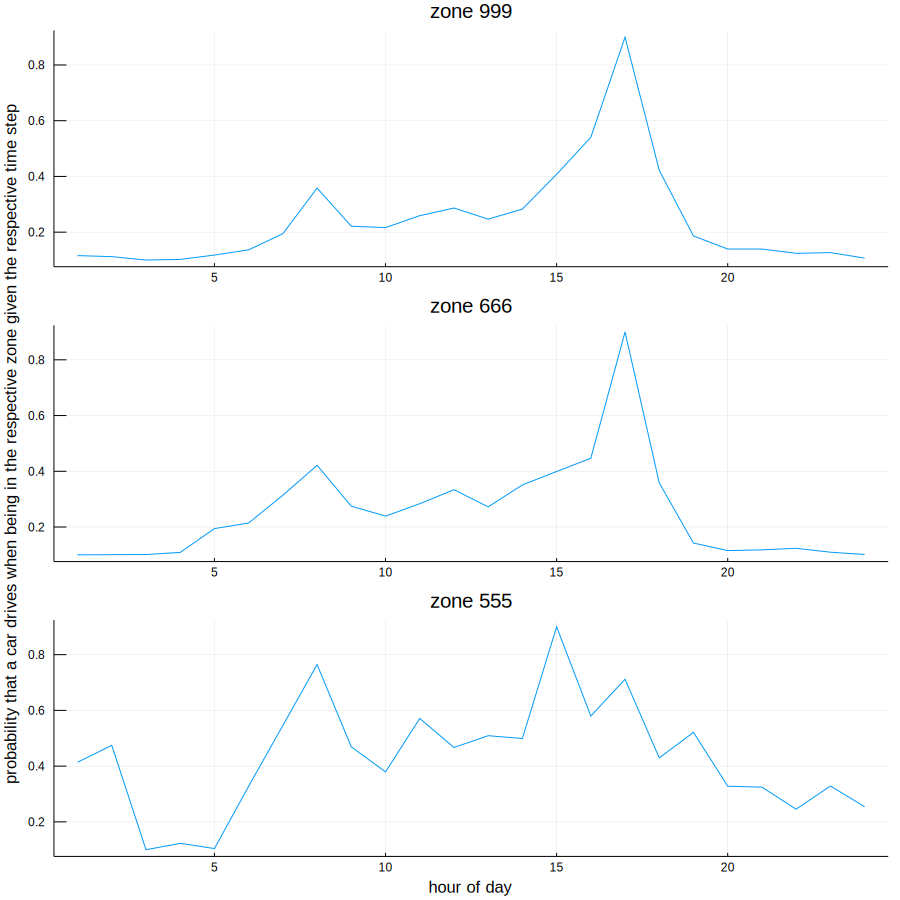

In [8]:
p_min = 0.1; # paramter that determines minimum driving probability
p_max = 0.9; # paramter that determines maximum driving probability
e_drive = 2; # An exponent that determines the circadian rhythm of driving activity. Can be changed.

p_drive = zeros(number_zones, T);
mean_sum = zeros(number_zones, T);
min_t = zeros(number_zones,1);
max_t = zeros(number_zones,1);

# Calculating the sums, minimum sums and maximum sums of mean travel time out of a zone
for i=1:number_zones    
    for t=1:T
        mean_sum[i, t] = 0;
        counter = 0;
        for j=1:number_zones
            if(datamatrix[i,j,t,1] != 0)
                mean_sum[i, t] = mean_sum[i, t] + datamatrix[i,j,t,1]/distance_matrix_km[i,j];
                counter += 1;
            end
        end
        mean_sum[i, t] = mean_sum[i, t]/counter;
    end
    max_t[i] = maximum(mean_sum[i,:]);
    min_t[i] = minimum(mean_sum[i,:]);
end

# Calculating the Bernoulli distributions p_drive
for i=1:number_zones
    if(max_t[i] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
        for t=1:T
            # A linear function for assigning a value of 10% to p_drive if min_t is given, and a value of 90% if max_t is given.
            p_drive[i,t] = p_min + (p_max - p_min) * ((mean_sum[i,t] - min_t[i]) / (max_t[i] - min_t[i]))^e_drive;  
        end
    end
end

x = 1:24;
y1 = plot(x, p_drive[999, :], title="zone 999");
y2 = plot(x, p_drive[666, :], title="zone 666", ylabel="probability that a car drives when being in the respective zone given the respective time step" );
y3 = plot(x, p_drive[555, :], title="zone 555", xlabel ="hour of day");

plot(y1,y2,y3,layout=(3,1), size=(900, 900), legend=false)

### 3.2 Popularity of destinations
When creating a stochastic distribution for sampling the travel destinations, we ask ourselves how likely it is that a car in zone i travels to zone j at a given point t in time. We start with comparing the mean travel times from any zone i (origin) to any other zone j (destination) at any time step t $\in$ [1,...,24] of the day with the highest and lowest mean travel time out of all time steps t = 1...T for the same origin-destination pair. Given that, we have an indicator of how "popular" a destination zone at that given time is, compared to other times of the day. We hence view an increased travel time to a certain destination at a given time as a hint that **relatively** many cars will travel into this destination zone. Given this logic, we naturally have inacurracies in the determined distributions: increased traffic and hence longer mean travel times can be caused due to overloaded capacities of roads **between** the origin and destination zones. We save the probabilities in a N X N X T matrix called p_dest. If we determine all entries of p_dest, we should have a Multinomial distribution for each zone and each time step of the day. This equals to 2,357 $\cdotp$ 24 = 56,568 distributions, or 2,357 $\cdotp$ 2,357 $\cdotp$ 24 = 133,330,776 single probabilities for our example of Melbourne. Note that a car can also travel to a destination within its origin zone.

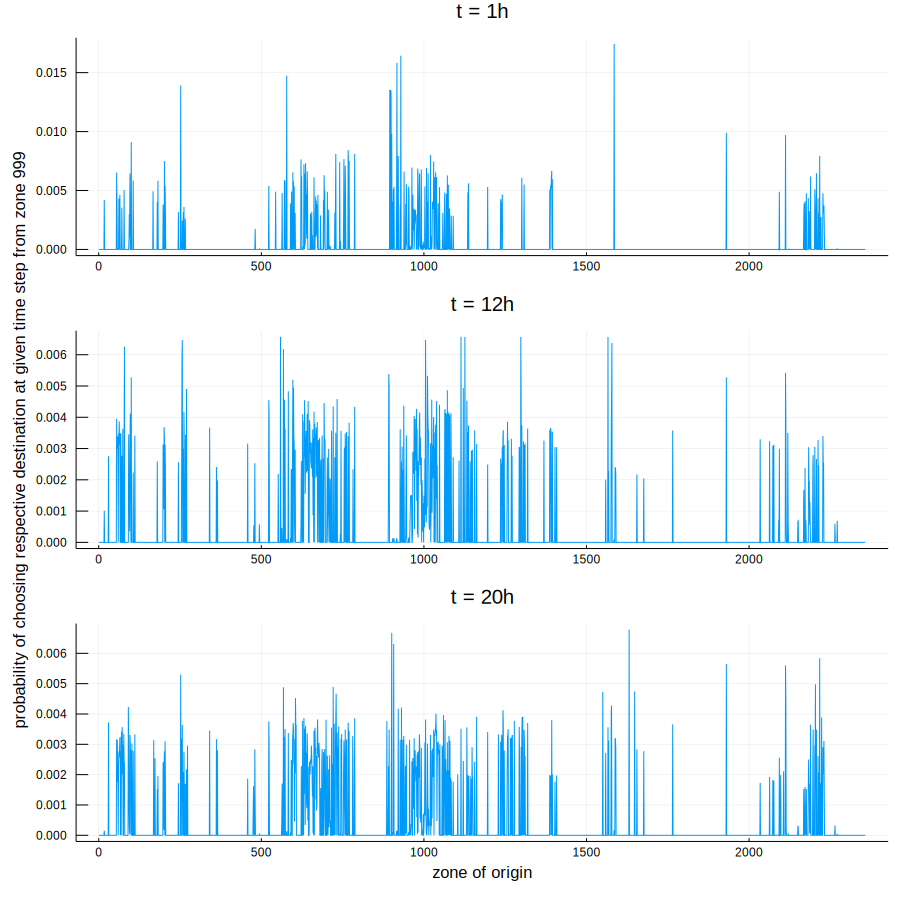

In [9]:
p_dest = zeros(number_zones, number_zones, T);
max_x = zeros(number_zones, number_zones);
min_x = zeros(number_zones, number_zones);
normalization_factor = zeros(number_zones, T);

e_dest = 2; # An exponent that determines the destination popularity. Can be changed.

# Calculating the minima and maxima of mean travel time 
for i=1:number_zones 
    # Calculating the minima and maxima
    for j=1:number_zones # destination zone ID
        max_x[i,j] = maximum(datamatrix[i, j, :, 1])
        min_x[i,j] = minimum(datamatrix[i, j, :, 1])
    end
end

# Calculating the unnormalized p_dest
for i=1:number_zones 
    for j=1:number_zones
        for t=1:T
            if (max_x[i, j] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
                mean = datamatrix[i, j, t, 1];
                p_dest[i, j, t] = ((mean - min_x[i, j])/ (max_x[i, j] - min_x[i, j]))^e_dest;
            end
        end
    end
end

# Calculating normalization factors
for i=1:number_zones
    for t=1:T
        normalization_factor[i, t] = sum(p_dest[i, :, t]);
    end
end

# Normalizing the probability distributions of p_dest
for i=1:number_zones 
    for t=1:T
        if(normalization_factor[i, t] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
            for j=1:number_zones
                p_dest[i, j, t] = p_dest[i, j, t] / normalization_factor[i, t];
            end
        end
    end
end

# Visualizing distribution for exemplar origin zone 21 and time steps 1h, 12h and 20h o'clock
x = 1:number_zones;
y1 = plot(x, p_dest[999,:, 1], title="t = 1h");
y2 = plot(x, p_dest[999,:, 12], title="t = 12h", ylabel="probability of choosing respective destination at given time step from zone 999" );
y3 = plot(x, p_dest[999,:, 20], title="t = 20h", xlabel ="zone of origin");

plot(y1,y2,y3,layout=(3,1), size=(900, 900), legend=false)

### Joint Origin-Destination probabilities
The joint event of driving and choosing a destination can be described by their joint probability distributions. This represents a more concise description of the Origion-Destination (OD) probabilities that are derived from the hypothesized relationships. 

In [10]:
p_Origin_Destination = zeros(number_zones,number_zones,T);

for i=1:number_zones
    for t=1:T
        multiplication_term = p_drive[i,t];
        if(multiplication_term != 0) 
            for j=1:number_zones
                p_Origin_Destination[i,j,t] = p_dest[i,j,t] * multiplication_term;
            end
        end
    end
end

---

## 4 Sampling
In this section, we use the stochastic distributions from above to sample the traffic behaviour of individual cars. The sampling process is all about filling two matrices with the information we want to model with respect to the state and state transitions of the system. We call these matrices **"state_matrix"** and **"transition_matrix"**. We define the state of the system as the location zone of each car. The state transition is then defined as the traffic of cars from one zone to another and the travel time and distance that is associated with each trip. In the following subsections, we explain how we fill these matrices stepwise with the information we are interested in. Modelers can add or remove sampling steps for customizing the state and state transition properties of the system.

Modelers can extend the state space of the here presented traffic model by assigning more properties to a car than just its location. Such properties can for instance be the states of charge of electric car batteries. Similar to the state of the system, also the state transition properties can be extended. Such extensions can for instance be carbon emissions, fuel consumption and transported amount of people for each trip.

### 4.1 Initializing the state

In order to make generally applicable statements about temporal and spatial distributions of vehicles, one can model a constant number of cars, let us say 1,000, per zone as the entire vehicle fleet. For Melbourne, this would give a total fleet of C = 2,357,000 vehicles and allows us to make statements about the relative distribution of the total fleet among the zones of a city if this is what interests us the most. In order to have a starting point for the simulation, we uniformly distribute the total number of cars on all zones of the city. This is later improved by a treatment as an Initial Value Problem. 

In [11]:
cars_per_zone = 1000;
C = number_zones * cars_per_zone;
C = trunc(Int, C); # transforms C from type Float64 to Integer. Necessary for subsequent matrix definitions. 
state_matrix = zeros(C, T); # C X T  matrix for saving states of the system, i.e. the location of cars in each timestep. The rows stand for car ID and the columns for the timestep.
transition_matrix = zeros(C, T, 4); # C X T X 4 matrix for saving state transitions of the system in each timestep. The entries for each car ID (C) and each time step (T) are the driving activity, destination, travel time and travel distance.
zone = 0;

# assigning a zone uniformely to each car
for i = 0:cars_per_zone:(C-cars_per_zone)
    zone += 1;
    for j=1:cars_per_zone
        state_matrix[i+j, 1] = zone; # each car receives a location zone in time step 1, i.e. at 1h o'clock 
    end  
end
state_matrix = round.(Int, state_matrix);
state_matrix # printing out state matrix with initial state in time step 1.

2357000×24 Array{Int64,2}:
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### 4.2 Sampling if a car drives
We use the entries of p_drive to decide whether a car drives or parks, given the time of the day and the location zone of a car. We demonstrate here, how excecuting this simulation step will fill the transition matrix if a car does not drive. In case that a car drives, we will need to choose a destination too; this happens in the next sampling step. 


In [12]:
for i=1:C
    origin = state_matrix[i,1];
    RndVar = rand();
    driving_probability = p_drive[origin,1];
    if(RndVar <= driving_probability)
        drive = 1;
    else
        drive = 0;
        transition_matrix[i,1,2]= origin;
    end
    transition_matrix[i,1,1] = drive;
end

### 4.3 Sampling travel destinations
The transition matrix is now filled for cars that do not drive. Here, we also fill the transition matrix for the cases in which a car was chosen to drive to another destination. The destination is chosen from the stochastic distributions of p_dest.

In [13]:
for i=1:C
    drive = transition_matrix[i,1,1];
    if (drive == 1)
        RndVar = rand();
        range_up = 0;
        range_low = 0;
        destination = 0; 
        origin = state_matrix[i,1];
        distribution = p_dest[origin, :, 1];
        if(sum(distribution) == 0) # this is the case that datamatrix has sparsity for the given origin zone
            destination = origin;
        else
            for j=1:number_zones  
                range_up = range_up + distribution[j];
                if(range_low < RndVar <= range_up)
                    destination = j;
                    break;
                end
                range_low = range_up;
            end
        end
        transition_matrix[i,1,2]= destination;
    end
end

### 4.4 Sampling travel durations
A stochastic distribution for sampling travel times can be derived directly from the mean and standard deviation of travel times between zones given by our original dataset. We assume a Gaussian/Normal distribution for sampling as it turns out that many random processes occurring in nature reveal this type of distribution.

In [14]:
for i=1:C
    origin = state_matrix[i,1,1];
    destination = round.(Int, transition_matrix[i,1,2]); # must turn this into integer variable for comparison
    if (origin != destination)
        mean = datamatrix[origin, destination, 1, 1];
        std_deviation = datamatrix[origin, destination, 1, 2];
        if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
            std_deviation = 0.1 * mean;
        end
        travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel time chosen from truncated normal distribution 
        transition_matrix[i,1,3] = travel_time;
    end
end

### 4.5 Sampling travel distances
In section 2, we determined a matrix called "distance_matrix_km". The entries of distance_matrix_km include the distance between each zone of the city. Here, we sample travel distances from a truncated normal distribution by taking the constant distance between the origin and destination zone as mean and a standard deviation of 10 percent of the mean. 

In [15]:
for i=1:C
    origin = state_matrix[i,1,1];
    destination = round.(Int, transition_matrix[i,1,2]);
    if (origin != destination)
        mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
        std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
        travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel distance chosen from truncated normal distribution.
        transition_matrix[i,1,4] = travel_distance; 
    end
end

### 4.6 State update
Afer we have determined the transition matrix, we can update the state matrix. The state matrix in any time step t+1 is equal to the transition matrix entries at time step t.

In [16]:
state_matrix[:,2] = transition_matrix[:,1,2];
state_matrix # to show the matrix

2357000×24 Array{Int64,2}:
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  

### 4.7 Initial Value Problem
An uniform distribution of cars over all zones of the city as the initial state of the traffic system is not a realistic assumption. Hence, we are looking for a more realistic system state to start with. In state estimation tasks this is known as the Initial Value Problem. We solve the Initial Value Problem here by assuming the state after T = 24 simulation steps as the initial state of the system, i.e. after a large share of the stochastic distributions came to application. The idea behind this approach is that we expect the spatial distribution of the vehicles to naturally shape and approach a more realistic initial scenario. This is visualized below. Note that this is a computationally intensive step.

4% of the Initial Value Problem is solved
8% of the Initial Value Problem is solved
13% of the Initial Value Problem is solved
17% of the Initial Value Problem is solved
21% of the Initial Value Problem is solved
26% of the Initial Value Problem is solved
30% of the Initial Value Problem is solved
34% of the Initial Value Problem is solved
39% of the Initial Value Problem is solved
43% of the Initial Value Problem is solved
47% of the Initial Value Problem is solved
52% of the Initial Value Problem is solved
56% of the Initial Value Problem is solved
60% of the Initial Value Problem is solved
65% of the Initial Value Problem is solved
69% of the Initial Value Problem is solved
73% of the Initial Value Problem is solved
78% of the Initial Value Problem is solved
82% of the Initial Value Problem is solved
86% of the Initial Value Problem is solved
91% of the Initial Value Problem is solved
95% of the Initial Value Problem is solved
100% of the Initial Value Problem is solved


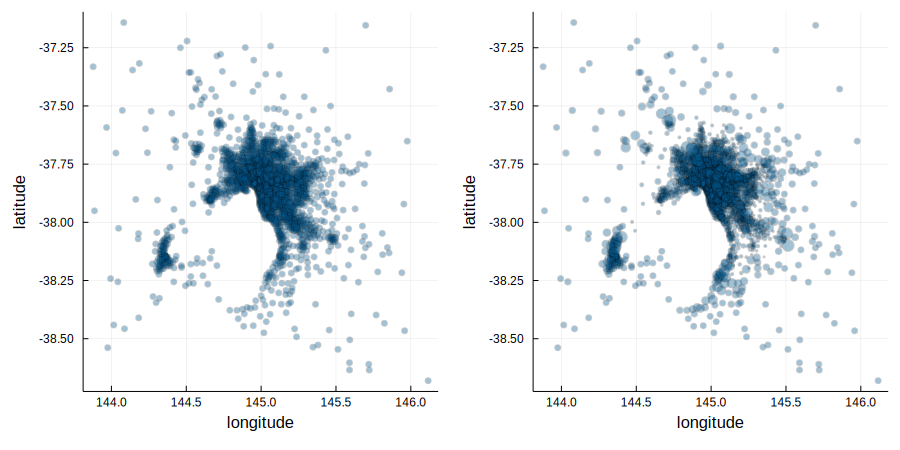

In [17]:
initial_state = zeros(C,1);

for t=1:(T-1)
    
    # Sampling if a car drives
    for i=1:C
        origin = state_matrix[i,t];
        RndVar = rand();
        driving_probability = p_drive[origin,t];
        if(RndVar <= driving_probability)
            drive = 1;
        else
            drive = 0;
            transition_matrix[i,t,2]= origin;
        end
        transition_matrix[i,t,1] = drive;
    end
    
    # Sampling travel destinations
    for i=1:C
        drive = transition_matrix[i,t,1];
        if (drive == 1)
            RndVar = rand();
            range_up = 0;
            range_low = 0;
            destination = 0;
            origin = state_matrix[i,t];
            distribution = p_dest[origin, :, t];
            if(sum(distribution) == 0)
                destination = origin;
            else
                for j=1:number_zones  
                    range_up = range_up + distribution[j];
                    if(range_low < RndVar <= range_up)
                        destination = j;
                        break;
                    end
                    range_low = range_up;
                end
            end
            transition_matrix[i,t,2] = destination;
        end
    end

    # State update
    state_matrix[:,t+1] = transition_matrix[:,t,2];
    println(trunc(Int,t/0.23),"% of the Initial Value Problem is solved")
end

initial_state = state_matrix[:,24];
initial_state = round.(Int, initial_state);

# Visualizing results
zone = zeros(number_zones,T);
for i=1:C
    for t=1:T
        index = state_matrix[i,t]
        zone[index,t] += 1;
    end
end
for i=1:number_zones
    for t=1:T
        zone[i,t] = sqrt(zone[i,t]);
    end
end
x = centroid_long;
y = centroid_lat;
gr();
areas1 = scatter(x,y, ms= zone[:,1] * 0.1, alpha=0.2);
areas2 = scatter(x,y,ms=zone[:,24] * 0.1, alpha=0.2);
plot(areas1,areas2,layout=(1,2), size=(900, 450), legend=false, xlabel="longitude", ylabel="latitude")

### 4.8 Resampling
If we simply continue the sampling process for conscutive days, we will reach a saturated state where all cars gather in one or few city zones. Resampling an entire day with improved initial state allows us to avoid this and replicate one sample per dataset for the simulation of multiple consecutive days/weeks/months/years. 

In [18]:
# Initial Value Problem: assume the state after 24 simulation steps as the initial state of the system
state_matrix[:,1] = initial_state; 

# Simulate an entire day with improved initial value
for t=1:T
    
    # Sampling if a car drives
    for i=1:C
        origin = state_matrix[i,t];
        RndVar = rand();
        driving_probability = p_drive[origin,t];
        if(RndVar <= driving_probability)
            drive = 1;
        else
            drive = 0;
            transition_matrix[i,t,2]= origin;
        end
        transition_matrix[i,t,1] = drive;
    end
    
    # Sampling travel destinations
    for i=1:C
        drive = transition_matrix[i,t,1];
        if (drive == 1)
            RndVar = rand();
            range_up = 0;
            range_low = 0;
            destination = 0;
            origin = state_matrix[i,t];
            distribution = p_dest[origin, :, t];
            if(sum(distribution) == 0)
                destination = origin;
            else
                for j=1:number_zones  
                    range_up = range_up + distribution[j];
                    if(range_low < RndVar <= range_up)
                        destination = j;
                        break;
                    end
                    range_low = range_up;
                end
            end
            transition_matrix[i,t,2]= destination;
        end
    end
    
    # Sampling travel times and distances 
    for i=1:C
        drive = transition_matrix[i,t,1];
        if(drive == 1)
            origin = state_matrix[i,t,1];
            destination = round.(Int, transition_matrix[i,t,2]);
            if(origin == destination) # this is the case that a car drives to a destination within the origin zone
                transition_matrix[i,t,3] = 5 * 60; # assuming arbitrarily a driving time of 5 minutes given in seconds
                transition_matrix[i,t,4] = 1; # assuming arbitraliy a driving distance of 1 km given in km. 
            else
                # sampling travel times
                mean = datamatrix[origin, destination, t, 1];
                std_deviation = datamatrix[origin, destination, t, 2];
                if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
                    std_deviation = 0.1 * mean;
                end
                travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel time chosen from truncated normal distribution 
                transition_matrix[i,t,3] = travel_time;

                # sampling travel distances
                mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
                std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
                travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel distance chosen from truncated normal distribution.
                transition_matrix[i,t,4] = travel_distance;
            end
        end
    end

    # State update
    if(t<T)
        state_matrix[:,t+1] = transition_matrix[:,t,2];
    end
    println(trunc(Int,t/0.23),"% of the dataset is simulated")
end

4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simulated
17% of the dataset is simulated
21% of the dataset is simulated
26% of the dataset is simulated
30% of the dataset is simulated
34% of the dataset is simulated
39% of the dataset is simulated
43% of the dataset is simulated
47% of the dataset is simulated
52% of the dataset is simulated
56% of the dataset is simulated
60% of the dataset is simulated
65% of the dataset is simulated
69% of the dataset is simulated
73% of the dataset is simulated
78% of the dataset is simulated
82% of the dataset is simulated
86% of the dataset is simulated
91% of the dataset is simulated
95% of the dataset is simulated
100% of the dataset is simulated
104% of the dataset is simulated


### 4.9 Normalizing

Our final results must be the geospatial distribution of cars for each time step that we simulate. We normalize these distributions by dividing the number of cars in each zone by the total number of vehicles we chose to sample. We receive the percentage of vehicles present in each zone in each time step. This is then further divided into the share of cars that drive and those that stay parked. These values can be scaled by the total number of cars which the modeler wants to sample. 

In [19]:
driving_cars = zeros(number_zones, T);
parking_cars = zeros(number_zones, T);

for i=1:C
    for t=1:T
        index = state_matrix[i,t];
        driving_activity = transition_matrix[i,t,1];
        parking_cars[index,t] += 1;
        if(driving_activity == 1)
            driving_cars[index,t] += 1;
        end
    end
end

parking_cars = parking_cars/C;
driving_cars = driving_cars/C;

# calculating circadian rhythm of driving activity
traffic_activity = transpose(sum(driving_cars,dims=1));
min_activity = minimum(traffic_activity); 
max_activity = maximum(traffic_activity); 
for i=1:24
    traffic_activity[i] = (traffic_activity[i]-min_activity)/(max_activity - min_activity);
end

### visualizing results for parking cars
for i=1:number_zones
    for t=1:T
        parking_cars[i,t] = sqrt(parking_cars[i,t]);
    end
end
x = centroid_long;
y = centroid_lat;
gr();
areas1 = scatter(x,y, ms= parking_cars[:,3] * 100, alpha=0.2, title="t = 3h");
areas2 = scatter(x,y,ms=parking_cars[:,6] * 100, alpha=0.2, title="t = 6h");
areas3 = scatter(x,y,ms=parking_cars[:,9] * 100, alpha=0.2, title="t = 9h");
areas4 = scatter(x,y,ms=parking_cars[:,12] * 100, alpha=0.2, title="t = 12h");
areas5 = scatter(x,y,ms=parking_cars[:,15] * 100, alpha=0.2, title="t = 15h");
areas6 = scatter(x,y,ms=parking_cars[:,18] * 100, alpha=0.2, title="t = 18h");
areas7 = scatter(x,y,ms=parking_cars[:,21] * 100, alpha=0.2, title="t = 21h");
areas8 = scatter(x,y,ms=parking_cars[:,24] * 100, alpha=0.2, title="t = 24h");
plot(areas1, areas2, areas3, areas4, areas5, areas6, areas7, areas8, layout=(4,2), size=(900,1800), legend=false, ylabel = "latitude", yticks =0, xticks =0, xlabel ="longitude")

---
## 5 Model selection

Our model contains four parameters that were preliminarily chosen arbitrarily. The first parameter is the exponent e_drive in the non-linear functional relationship that translates the mean travel time between different city zones into the probability of driving (section 3.1); it was intially set to a value of 2. The second and third parameters are p_min and p_max that determine the range of probabilities according to which we decide whether a car drives or parks given the time of the day and the location zone; they were initially set to 0.1 and 0.9 respectively (section 3.1). The last parameter is the exponent e_dest which translates mean travel times into the probabilities of choosing a destination zone for a trip (section 3.2). In this section, we introduce three distinct optimization algorithms for making sequentially a good choice of these parameters based on validation results.  

### 5.1 Choosing e_drive

A first substantial hypothesis in our model is, that whether a car drives to another city zone or stays parked in its origin zone is a function of changing travel times from the car's current location to all possible destination zones throughout a day. This means, that the higher the measured travel times at a certain time of a day in a particular city zone are, the more likely it is that a car will undertake a trip to another destination at that given time of the day. This generates a characteristic circadian profiles of traffic activity. The parameter e_drive determines the shape of this circadian rhythm in our model (section 3.1). The closer we choose e_drive to a value of zero, the smoother will the gradients be that translate travel time to the probability of driving. We can evaluate real observations of traffic activity to make a good choice for e_drive. Here, we use the number of vehicles counted on street segments in the city of Melbourne as an indicator for traffic activity. We implement a gradient descent optimization algorithm that exploits adaptive step size techniques to find a good value for e_drive in our model. Note that this is a non-convex optimization problem. Therefore, the starting value of e_drive is of large importance for the model selection. We first try different initial values and start the optimization for the best results among these. 

Evaluation error with initial e_drive =  2: 11%
4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simulated
17% of the dataset is simulated
21% of the dataset is simulated
26% of the dataset is simulated
30% of the dataset is simulated
34% of the dataset is simulated
39% of the dataset is simulated
43% of the dataset is simulated
47% of the dataset is simulated
52% of the dataset is simulated
56% of the dataset is simulated
60% of the dataset is simulated
65% of the dataset is simulated
69% of the dataset is simulated
73% of the dataset is simulated
78% of the dataset is simulated
82% of the dataset is simulated
86% of the dataset is simulated
91% of the dataset is simulated
95% of the dataset is simulated
100% of the dataset is simulated
104% of the dataset is simulated
Evaluation error with alternative e_drive =  1.0: 4%
4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simulated
17% of the dataset is simulated
21% o

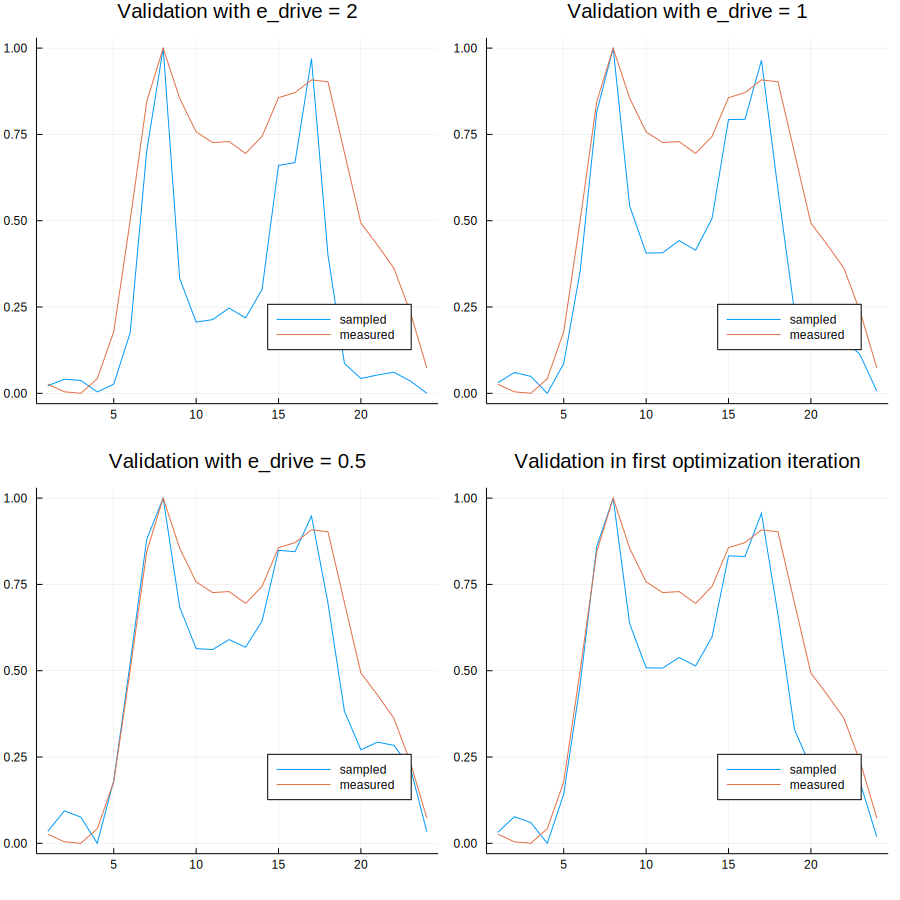

In [20]:
### Load measured traffic activity data for the ciy of Melbourne
@load "traffic_activity_measured.jld2" #traffic_activity_weekday traffic_activity_weekend
traffic_activity_measured = traffic_activity_weekday[:,1,4]; # index 1 is for quarter 1, index 4 is for the year 2017


### Step 1: Calculate error with current parameter e_drive
evaluation_error_0 = 0;
traffic_activity_0 = traffic_activity;
for t = 1:24
    evaluation_error_0 = evaluation_error_0 + (traffic_activity_measured[t] - traffic_activity_0[t])^2;
end
evaluation_error_0 = evaluation_error_0/24;
println("Evaluation error with initial e_drive =  ",e_drive,": ", floor(Int, 100 * evaluation_error_0),"%")


### Step 2: Calculate error with alternative values for e_drive
list_e_drive = [1, 0.5];
best_initial_parameter = e_drive;
best_evaluation_result = evaluation_error_0;
traffic_activity_alternatives = zeros(24,length(list_e_drive));
for e_drive_counter=1:length(list_e_drive)
    
    ### Step 2.1: Calculate new p_drive
    e_drive = list_e_drive[e_drive_counter];
    p_drive = zeros(number_zones, T);
    mean_sum = zeros(number_zones, T);
    min_t = zeros(number_zones,1);
    max_t = zeros(number_zones,1);
    # Calculating the sums, minimum sums and maximum sums of mean travel time out of a zone
    for i=1:number_zones    
        for t=1:T
            mean_sum[i, t] = 0;
            counter = 0;
            for j=1:number_zones
                if(datamatrix[i,j,t,1] != 0)
                    mean_sum[i, t] = mean_sum[i, t] + datamatrix[i,j,t,1]/distance_matrix_km[i,j];
                    counter += 1;
                end
            end
            mean_sum[i, t] = mean_sum[i, t]/counter;
        end
        max_t[i] = maximum(mean_sum[i,:]);
        min_t[i] = minimum(mean_sum[i,:]);
    end
    # Calculating the Bernoulli distributions p_drive
    for i=1:number_zones
        if(max_t[i] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
            for t=1:T
                # A linear function for assigning a value of 10% to p_drive if min_t is given, and a value of 90% if max_t is given.
                p_drive[i,t] = p_min + (p_max - p_min) * ((mean_sum[i,t] - min_t[i]) / (max_t[i] - min_t[i]))^e_drive;  
            end
        end
    end

    
    ### Step 2.2: Sample entire day with new p_drive
    # Initial Value Problem: assume the state after 24 simulation steps as the initial state of the system
    state_matrix[:,1] = initial_state; 
    # Simulate an entire day with improved initial value
    for t=1:T

        # Sampling if a car drives
        for i=1:C
            origin = state_matrix[i,t];
            RndVar = rand();
            driving_probability = p_drive[origin,t];
            if(RndVar <= driving_probability)
                drive = 1;
            else
                drive = 0;
                transition_matrix[i,t,2]= origin;
            end
            transition_matrix[i,t,1] = drive;
        end
        # Sampling travel destinations
        for i=1:C
            drive = transition_matrix[i,t,1];
            if (drive == 1)
                RndVar = rand();
                range_up = 0;
                range_low = 0;
                destination = 0;
                origin = state_matrix[i,t];
                distribution = p_dest[origin, :, t];
                if(sum(distribution) == 0)
                    destination = origin;
                else
                    for j=1:number_zones  
                        range_up = range_up + distribution[j];
                        if(range_low < RndVar <= range_up)
                            destination = j;
                            break;
                        end
                        range_low = range_up;
                    end
                end
                transition_matrix[i,t,2]= destination;
            end
        end
        # Sampling travel times and distances 
        for i=1:C
            drive = transition_matrix[i,t,1];
            if(drive == 1)
                origin = state_matrix[i,t,1];
                destination = round.(Int, transition_matrix[i,t,2]);
                if(origin == destination) # this is the case that a car drives to a destination within the origin zone
                    transition_matrix[i,t,3] = 5 * 60; # assuming arbitrarily a driving time of 5 minutes given in seconds
                    transition_matrix[i,t,4] = 1; # assuming arbitraliy a driving distance of 1 km given in km. 
                else
                    # sampling travel times
                    mean = datamatrix[origin, destination, t, 1];
                    std_deviation = datamatrix[origin, destination, t, 2];
                    if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
                        std_deviation = 0.1 * mean;
                    end
                    travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel time chosen from truncated normal distribution 
                    transition_matrix[i,t,3] = travel_time;

                    # sampling travel distances
                    mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
                    std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
                    travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel distance chosen from truncated normal distribution.
                    transition_matrix[i,t,4] = travel_distance;
                end
            end
        end
        # State update
        if(t<T)
            state_matrix[:,t+1] = transition_matrix[:,t,2];
        end
        println(trunc(Int,t/0.23),"% of the dataset is simulated")
    end
    # Normalization
    driving_cars = zeros(number_zones, T);
    parking_cars = zeros(number_zones, T);
    for i=1:C
        for t=1:T
            index = state_matrix[i,t];
            driving_activity = transition_matrix[i,t,1];
            parking_cars[index,t] += 1;
            if(driving_activity == 1)
                driving_cars[index,t] += 1;
            end
        end
    end
    parking_cars = parking_cars/C;
    driving_cars = driving_cars/C;
    # calculating circadian rhythm of driving activity
    traffic_activity = transpose(sum(driving_cars,dims=1));
    min_activity = minimum(traffic_activity); 
    max_activity = maximum(traffic_activity); 
    for i=1:24
        traffic_activity[i] = (traffic_activity[i]-min_activity)/(max_activity - min_activity);
    end
    traffic_activity_alternatives[:,e_drive_counter] = traffic_activity;
    
    
    ### Step 2.3: Calculate evaluation error for current e_drive and p_drive
    evaluation_error = 0;
    for t = 1:24
        evaluation_error = evaluation_error + (traffic_activity_measured[t] - traffic_activity[t])^2;
    end
    evaluation_error = evaluation_error/24;
    println("Evaluation error with alternative e_drive =  ",e_drive,": ", floor(Int, 100 * evaluation_error),"%")
    
    
    ### Step 2.4: Update best initial parameter if its evaluation error is smaller than the currently best parameter
    if(evaluation_error < best_evaluation_result)
        best_evaluation_result = evaluation_error;
        best_initial_parameter = e_drive;
    end     
end

println("The best initial parameter among the listed once is e_drive = ", e_drive," with an evaluation error of: ",best_evaluation_result)


### Step 3: Start optimization algorithm with best initial parameter 
step_size_param = 10;
max_iter = 3;
epsilon = 0.001;

### Step 3.1: Taking a step into arbitrary direction
e_drive = e_drive + step_size_param * best_evaluation_result;
traffic_activity_optimizationresults = zeros(24,max_iter);

### Step 3.2: Sample until convergence
n = 1;
while n <= max_iter
    
    ### Step 3.2.1: Calculate new p_drive
    p_drive = zeros(number_zones, T);
    mean_sum = zeros(number_zones, T);
    min_t = zeros(number_zones,1);
    max_t = zeros(number_zones,1);
    println("Simulating at iteration n = ",n)
    # Calculating the sums, minimum sums and maximum sums of mean travel time out of a zone
    for i=1:number_zones    
        for t=1:T
            mean_sum[i, t] = 0;
            counter = 0;
            for j=1:number_zones
                if(datamatrix[i,j,t,1] != 0)
                    mean_sum[i, t] = mean_sum[i, t] + datamatrix[i,j,t,1]/distance_matrix_km[i,j];
                    counter += 1;
                end
            end
            mean_sum[i, t] = mean_sum[i, t]/counter;
        end
        max_t[i] = maximum(mean_sum[i,:]);
        min_t[i] = minimum(mean_sum[i,:]);
    end
    # Calculating the Bernoulli distributions p_drive
    for i=1:number_zones
        if(max_t[i] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
            for t=1:T
                # A linear function for assigning a value of 10% to p_drive if min_t is given, and a value of 90% if max_t is given.
                p_drive[i,t] = p_min + (p_max - p_min) * ((mean_sum[i,t] - min_t[i]) / (max_t[i] - min_t[i]))^e_drive;  
            end
        end
    end
    
    ### Step 3.2.2: Sample entire day with new p_drive
    # Initial Value Problem: assume the state after 24 simulation steps as the initial state of the system
    state_matrix[:,1] = initial_state; 
    # Simulate an entire day with improved initial value
    for t=1:T
        # Sampling if a car drives
        for i=1:C
            origin = state_matrix[i,t];
            RndVar = rand();
            driving_probability = p_drive[origin,t];
            if(RndVar <= driving_probability)
                drive = 1;
            else
                drive = 0;
                transition_matrix[i,t,2]= origin;
            end
            transition_matrix[i,t,1] = drive;
        end
        # Sampling travel destinations
        for i=1:C
            drive = transition_matrix[i,t,1];
            if (drive == 1)
                RndVar = rand();
                range_up = 0;
                range_low = 0;
                destination = 0;
                origin = state_matrix[i,t];
                distribution = p_dest[origin, :, t];
                if(sum(distribution) == 0)
                    destination = origin;
                else
                    for j=1:number_zones  
                        range_up = range_up + distribution[j];
                        if(range_low < RndVar <= range_up)
                            destination = j;
                            break;
                        end
                        range_low = range_up;
                    end
                end
                transition_matrix[i,t,2]= destination;
            end
        end
        # Sampling travel times and distances 
        for i=1:C
            drive = transition_matrix[i,t,1];
            if(drive == 1)
                origin = state_matrix[i,t,1];
                destination = round.(Int, transition_matrix[i,t,2]);
                if(origin == destination) # this is the case that a car drives to a destination within the origin zone
                    transition_matrix[i,t,3] = 5 * 60; # assuming arbitrarily a driving time of 5 minutes given in seconds
                    transition_matrix[i,t,4] = 1; # assuming arbitraliy a driving distance of 1 km given in km. 
                else
                    # sampling travel times
                    mean = datamatrix[origin, destination, t, 1];
                    std_deviation = datamatrix[origin, destination, t, 2];
                    if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
                        std_deviation = 0.1 * mean;
                    end
                    travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel time chosen from truncated normal distribution 
                    transition_matrix[i,t,3] = travel_time;

                    # sampling travel distances
                    mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
                    std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
                    travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel distance chosen from truncated normal distribution.
                    transition_matrix[i,t,4] = travel_distance;
                end
            end
        end
        # State update
        if(t<T)
            state_matrix[:,t+1] = transition_matrix[:,t,2];
        end
        println(trunc(Int,t/0.23),"% of the dataset is simulated")
    end
    # Normalization
    driving_cars = zeros(number_zones, T);
    parking_cars = zeros(number_zones, T);
    for i=1:C
        for t=1:T
            index = state_matrix[i,t];
            driving_activity = transition_matrix[i,t,1];
            parking_cars[index,t] += 1;
            if(driving_activity == 1)
                driving_cars[index,t] += 1;
            end
        end
    end
    parking_cars = parking_cars/C;
    driving_cars = driving_cars/C;
    # calculating circadian rhythm of driving activity
    traffic_activity = transpose(sum(driving_cars,dims=1));
    min_activity = minimum(traffic_activity); 
    max_activity = maximum(traffic_activity); 
    for i=1:24
        traffic_activity[i] = (traffic_activity[i]-min_activity)/(max_activity - min_activity);
    end
    traffic_activity_optimizationresults[:,n] = traffic_activity;
    
    ### Step 3.2.3: Calculate evaluation error for current e_drive and p_drive
    evaluation_error = 0;
    for t = 1:24
        evaluation_error = evaluation_error + (traffic_activity_measured[t] - traffic_activity[t])^2;
    end
    evaluation_error = evaluation_error/24;
    println("Evaluation error at iteration ",n ," with e_drive =  ",e_drive,": ", floor(Int, 100 * evaluation_error),"%")
    
    ### Step 3.2.4: Calculate error and parameter gradient:
    error_gradient = evaluation_error - best_evaluation_result;
    param_gradient = e_drive - best_initial_parameter;
    
    ### Step 3.2.5: Update best initial parameter if its evaluation error is smaller than the currently best parameter, reset parameter otherwise
    if(error_gradient < 0)
        best_evaluation_result = evaluation_error;
        best_initial_parameter = e_drive;
    else
        e_drive = best_initial_parameter;
    end

    ### Step 3.2.6: Parameter update
    e_drive = e_drive - step_size_param * error_gradient/param_gradient;
    
    ### Step 3.2.7: Terminate for good solutions or convergence
    if(best_evaluation_result < 0.02)
        println("Without convergence towards a local minimum, a good solution is already found for e_drive = ", best_initial_parameter," with an error of ", floor(Int, 100 * best_evaluation_result),"%")
        break;
    end
    if(abs(error_gradient) < epsilon)
        println("Algorithm converged towards a local minimum for e_drive = ", best_initial_parameter," with an error of ", floor(Int, 100 * best_evaluation_result),"%")
        break;
    end
    
    ### Step 3.2.8: Increment iterator
    global n+= 1;
    
end

e_drive = best_initial_parameter;

### Plot the results
string_plot_title = string("Validation with e_drive = 2");
y1 = plot(traffic_activity_0, label="sampled", title = string_plot_title, legend = :bottomright);
y1 = plot!(y1, traffic_activity_measured, label="measured");

string_plot_title = string("Validation with e_drive = 1");
y2 = plot(traffic_activity_alternatives[:,1], label="sampled", title = string_plot_title, legend = :bottomright);
y2 = plot!(y2, traffic_activity_measured, label="measured");

string_plot_title = string("Validation with e_drive = 0.5");
y3 = plot(traffic_activity_alternatives[:,2], label="sampled", title = string_plot_title, legend = :bottomright);
y3 = plot!(y3, traffic_activity_measured, label="measured");

string_plot_title = string("Validation in first optimization iteration");
y4 = plot(traffic_activity_optimizationresults[:,1], label="sampled", title = string_plot_title, legend = :bottomright);
y4 = plot!(y4, traffic_activity_measured, label="measured");

plot(y1,y2,y3,y4, layout=(2,2), size=(900,900))

### 5.2 Choosing p_min and p_max

The parameters p_min and p_max determine the range of probabilities according to which we decide whether a car drives or parks given the time of the day and the location zone. In order to improve their values and achieve a more realistic model, we introduce:
* A<sub>set</sub> := the realistic amount of driving time within the lifetime of a vehicle.
* A<sub>drive</sub> := the sampled amount of driving time within the lifetime of a vehicle.

We can use observed values of average travel time in Australia to select good values for p_min and p_max. If we for instance assume that cars in Australia are typically parked around 93% of their life time, then the realistic set point value to which we want to approach the relative driving time per day in our model is  A<sub>set</sub>=0.07. Other possible set point values for choosing appropriate parameters for the traffic system could be the number of undertaken trips or the average travel distance. We calculate the average driving time before normalizing and introduce a numeric iterative algorithm which then improves the values of p_min and p_max accordingly. We keep track of the changes in the circadian rhythm of traffic activity while tuning p_min and p_max and find that changing these parameters does not affect the previously optmized circadian traffic rhythm.

Without model selection for p_min and p_max, the simulated cars drive around 20% of their lifetime.
Simulating at iteration n = 1
4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simulated
17% of the dataset is simulated
21% of the dataset is simulated
26% of the dataset is simulated
30% of the dataset is simulated
34% of the dataset is simulated
39% of the dataset is simulated
43% of the dataset is simulated
47% of the dataset is simulated
52% of the dataset is simulated
56% of the dataset is simulated
60% of the dataset is simulated
65% of the dataset is simulated
69% of the dataset is simulated
73% of the dataset is simulated
78% of the dataset is simulated
82% of the dataset is simulated
86% of the dataset is simulated
91% of the dataset is simulated
95% of the dataset is simulated
100% of the dataset is simulated
104% of the dataset is simulated
The simulated vehicles drive around 9% of their lifetime. This gives a △A = [-0.139509; -0.0207787; 0.

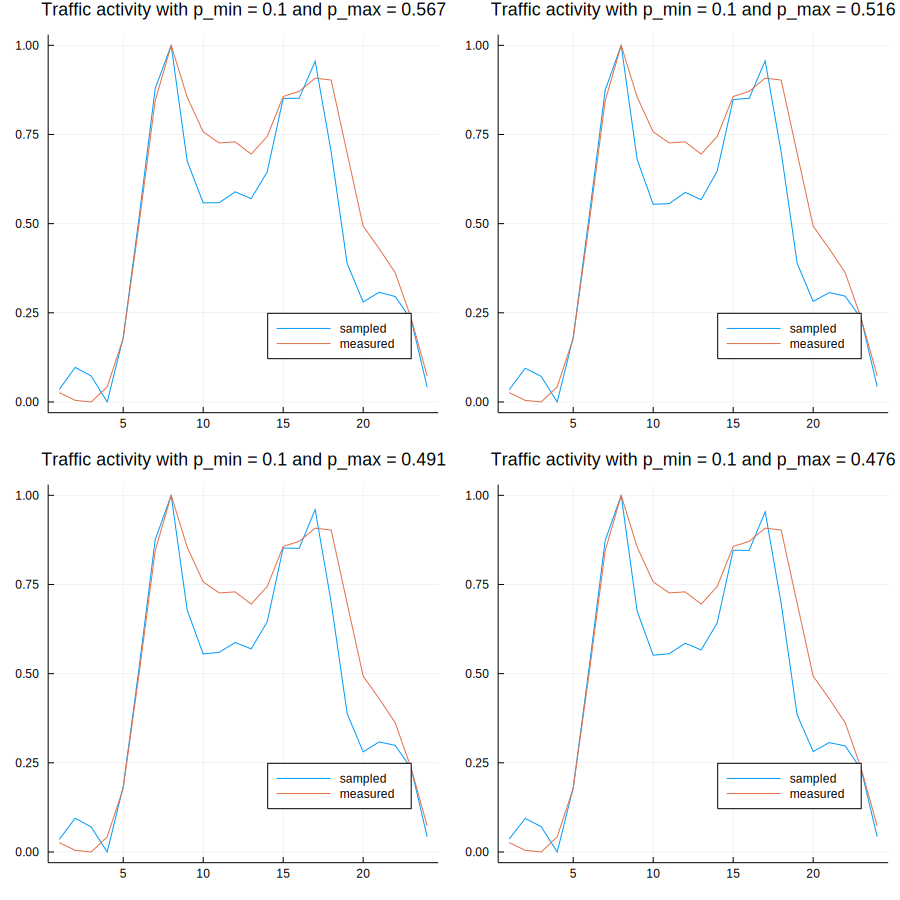

In [21]:
### Step 1: Initializing values
A_set = 0.07;
max_iter = 5;
p_min = zeros(max_iter,1);
p_max = zeros(max_iter,1);
A_drive = zeros(max_iter,1);
△A = zeros(max_iter,1);
p_min[1] = 0.1;
p_max[1] = 0.9;
traffic_activity_progress = zeros(24,max_iter);
#Calculating driving time before parameter tuning
sum_driving_time = 0;
driving_time_entries = zeros(C,1);
for t=1:T
    driving_time_entries = transition_matrix[:,t,3];
    sum_driving_time = sum_driving_time + sum(driving_time_entries);
end
A_drive[1] = sum_driving_time/(C * T * 60 * 60); # travel times are recorded in seconds.
△A[1] = A_set - A_drive[1];


### Print out results without model selection
println("Without model selection for p_min and p_max, the simulated cars drive around ",trunc(Int,A_drive[1] * 100),"% of their lifetime.")


### Step 2: Until convergence, do
n = 2; 
while n <= max_iter
    

    ###Step 2.1 (5): Choosing which equation to solve, depending on whether parameters reached bounds or not.
    if(p_max[n-1]==1)
        if(p_min[n-1]==p_max[n-1])
            println("something went wrong! p_min is equal to p_max!");
            break
        else
            p_min[n] = p_min[n-1] + (p_max[n-1] + p_min[n-1]) * △A[n-1] / (n * A_drive[n-1]);
            p_max[n] = p_max[n-1];
        end
    else
        if(p_min[n-1]==0)
            if(p_min[n-1]==p_max[n-1])
                println("something went wrong! p_min is equal to p_max!");
                break
            else
                p_max[n] = p_max[n-1] + (p_max[n-1] + p_min[n-1]) * △A[n-1] / (n * A_drive[n-1]);
                p_min[n] = p_min[n-1];
            end
        else
            if(p_min[n-1]==p_max[n-1])
                p_min[n] = p_min[n-1] + (p_max[n-1] + p_min[n-1]) * △A[n-1] / (n * A_drive[n-1]);
                p_max[n] = p_max[n-1];
            else
                p_max[n] = p_max[n-1] + (p_max[n-1] + p_min[n-1]) * △A[n-1] / (n * A_drive[n-1]);
                p_min[n] = p_min[n-1];
            end
        end
    end
    
    
    ###Step 2.2 (6): Correcting new parameters in case they cross any feasible bounds. 
    if(p_min[n]<0)
        p_min[n] = 0;
    else
        if(p_min[n]>p_max[n-1])
            p_min[n] = p_max[n-1];
        end
    end
    if(p_max[n]>1)
        p_max[n] = 1;
    else
        if(p_max[n]<p_min[n-1])
            p_max[n] = p_min[n-1];
        end
    end
    
    
    ###Step 2.3 (2): starting sampling loop. The first iteration is just the same as the entire sampling procedure above, without solving the initial value problem.
    # determining weather a car drives or parks
    p_drive = zeros(number_zones, T);
    mean_sum = zeros(number_zones, T);
    min_t = zeros(number_zones,1);
    max_t = zeros(number_zones,1);
    println("Simulating at iteration n = ",n-1)
    # Calculating the sums, minimum sums and maximum sums of mean travel time out of a zone
    for i=1:number_zones    
        for t=1:T
            mean_sum[i, t] = 0;
            counter = 0;
            for j=1:number_zones
                if(datamatrix[i,j,t,1] != 0)
                    mean_sum[i, t] = mean_sum[i, t] + datamatrix[i,j,t,1]/distance_matrix_km[i,j];
                    counter += 1;
                end
            end
            mean_sum[i, t] = mean_sum[i, t]/counter;
        end
        max_t[i] = maximum(mean_sum[i,:]);
        min_t[i] = minimum(mean_sum[i,:]);
    end
    # Calculating the Bernoulli distributions p_drive
    for i=1:number_zones
        if(max_t[i] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
            for t=1:T
                # A linear function for assigning a value of 10% to p_drive if min_t is given, and a value of 90% if max_t is given.
                p_drive[i,t] = p_min[n] + (p_max[n] - p_min[n]) * ((mean_sum[i,t] - min_t[i]) / (max_t[i] - min_t[i]))^e_drive;  
            end
        end
    end

    # Simulate an entire day with improved initial value
    state_matrix = zeros(C, T); # C X T  matrix for saving states of the system, i.e. the location of cars in each timestep. The rows stand for car ID and the columns for the timestep.
    transition_matrix = zeros(C, T, 4); # C X T X 4 matrix for saving state transitions of the system in each timestep. The entries for each car ID (C) and each time step (T) are the binary Drive or Park, the location of destination, travel 
    state_matrix[:,1] = initial_state;
    state_matrix = round.(Int, state_matrix);
    for t=1:T
        # Sampling if a car drives
        for i=1:C
            origin = state_matrix[i,t];
            RndVar = rand();
            driving_probability = p_drive[origin,t];
            if(RndVar <= driving_probability)
                drive = 1;
            else
                drive = 0;
                transition_matrix[i,t,2]= origin;
            end
            transition_matrix[i,t,1] = drive;
        end
        # Sampling travel destinations
        for i=1:C
            drive = transition_matrix[i,t,1];
            if (drive == 1)
                RndVar = rand();
                range_up = 0;
                range_low = 0;
                destination = 0;
                origin = state_matrix[i,t];
                distribution = p_dest[origin,:,t];
                if(sum(distribution) == 0)
                    destination = origin;
                else
                    for j=1:number_zones  
                        range_up = range_up + distribution[j];
                        if(range_low < RndVar <= range_up)
                            destination = j;
                            break;
                        end
                        range_low = range_up;
                    end
                end
                transition_matrix[i,t,2]= destination;
            end
        end
        # sampling travel times and distances 
        for i=1:C
            drive = transition_matrix[i,t,1];
            if(drive == 1)
                origin = state_matrix[i,t,1];
                destination = round.(Int, transition_matrix[i,t,2]);
                if(origin == destination) # this is the case that a car drives to a destination within the origin zone
                    transition_matrix[i,t,3] = 5 * 60; # assuming arbitrarily a driving time of 5 minutes given in seconds
                    transition_matrix[i,t,4] = 1; # assuming arbitraliy a driving distance of 1 km given in km. 
                else
                    # sampling travel times
                    mean = datamatrix[origin, destination, t, 1];
                    std_deviation = datamatrix[origin, destination, t, 2];
                    if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
                        std_deviation = 0.1 * mean;
                    end
                    travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel time chosen from truncated normal distribution 
                    transition_matrix[i,t,3] = travel_time;

                    # sampling travel distances
                    mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
                    std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
                    travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel distance chosen from truncated normal distribution.
                    transition_matrix[i,t,4] = travel_distance;
                end
            end
        end
        # state update
        if(t<T)
            state_matrix[:,t+1] = transition_matrix[:,t,2];
        end
        println(trunc(Int,t/0.23),"% of the dataset is simulated")
    end
    # Normalization
    driving_cars = zeros(number_zones, T);
    global parking_cars = zeros(number_zones, T);
    for i=1:C
        for t=1:T
            index = state_matrix[i,t];
            driving_activity = transition_matrix[i,t,1];
            parking_cars[index,t] += 1;
            if(driving_activity == 1)
                driving_cars[index,t] += 1;
            end
        end
    end
    parking_cars = parking_cars/C;
    driving_cars = driving_cars/C;
    # calculating circadian rhythm of driving activity
    traffic_activity = transpose(sum(driving_cars,dims=1));
    min_activity = minimum(traffic_activity); 
    max_activity = maximum(traffic_activity); 
    for i=1:24
        traffic_activity[i] = (traffic_activity[i]-min_activity)/(max_activity - min_activity);
    end
    traffic_activity_progress[:,n-1] = traffic_activity;
    
    
    ### Step 2.4 (3): Calculating A_drive and △A 
    sum_driving_time = 0;
    driving_time_entries = zeros(C,1);
    for t=1:T
        driving_time_entries = transition_matrix[:,t,3];
        sum_driving_time = sum_driving_time + sum(driving_time_entries);
    end
    A_drive[n] = sum_driving_time/(C * T * 60 * 60);
    △A[n] = A_set - A_drive[n];
    println("The simulated vehicles drive around ",trunc(Int, A_drive[n] * 100),"% of their lifetime. This gives a △A = ",△A," at iteration n = ",n," with p_min = ", p_min," and p_max = ",p_max);
        
    
    ###Step 2.5 (4): Checking if solution is improved and resetting parameter values if this is not the case.
    if(trunc(Int,A_set * 100) == trunc(Int,A_drive[n] * 100))
        println("A good solution is found for p_min = ",p_min[n]," and p_max = ",p_max[n]);
        break
    end
    if(n > 2 && abs(△A[n]) > abs(△A[n-1]))
        println("The parameters p_min = ",p_min[n]," and p_max = ",p_max[n]," lead to |△A| = ",abs(△A[n]),". This is worse than the last solution so we reset the parameters to p_min = ",p_min[n-1]," and p_max = ",p_max[n-1]);
        p_min[n] = p_min[n-1];
        p_max[n] = p_max[n-1];
        △A[n] = A_set - A_drive[n-1];
        A_drive[n] = A_drive[n-1];
    end

    ### Increment iterator
    global n += 1;
    
end


if(n > max_iter)
    println("Maximum number of iterations is reached. Best found solution is p_min = ",p_min[n-1]," and p_max = ",p_max[n-1])
end


### Plot the results
string_plot_title = string("Traffic activity with p_min = ", round(p_min[2],digits=3)," and p_max = ", round(p_max[2],digits=3));
y1 = plot(traffic_activity_progress[:,1], label="sampled", title = string_plot_title, legend = :bottomright, titlefont=12);
y1 = plot!(y1, traffic_activity_measured, label="measured");

string_plot_title = string("Traffic activity with p_min = ", round(p_min[3],digits=3)," and p_max = ", round(p_max[3],digits=3));
y2 = plot(traffic_activity_progress[:,2], label="sampled", title = string_plot_title, legend = :bottomright, titlefont=12);
y2 = plot!(y2, traffic_activity_measured, label="measured");

string_plot_title = string("Traffic activity with p_min = ", round(p_min[4],digits=3)," and p_max = ", round(p_max[4],digits=3));
y3 = plot(traffic_activity_progress[:,3], label="sampled", title = string_plot_title, legend = :bottomright, titlefont=12);
y3 = plot!(y3, traffic_activity_measured, label="measured");

string_plot_title = string("Traffic activity with p_min = ", round(p_min[5],digits=3)," and p_max = ", round(p_max[5],digits=3));
y4 = plot(traffic_activity_progress[:,4], label="sampled", title = string_plot_title, legend = :bottomright, titlefont=12);
y4 = plot!(y4, traffic_activity_measured, label="measured");

plot(y1,y2,y3,y4, layout=(2,2), size=(900,900))

### 5.3 Choosing e_dest

A second substantial hypothesis in our model is that the destination zone that a car will choose for a trip is a function of the traffic activity in that zone at that given time of the day. This means, that the higher the measured travel times to a particular city zone are, the more likely it is that cars will choose that zone as a destination. This generates characteristic flow directions of cars and the spatio-temporal distribution of cars among the zones of a city that we validate here.

In [22]:
### Assume the best solutions for parameters found in the previous model selection step
p_min = p_min[n-1];
p_max = p_max[n-1];

In [23]:
### Load measured parking density data for the ciy of Melbourne
@load "parking_density_measured.jld2" #measurementmatrix_weekday measurementmatrix_weekend; format: (number_zones,quarter,daytime)
parking_density_measured = measurementmatrix_weekday[:,1,:]; 


### Step 1: Calculate error with current parameter e_drive
min_sampled = zeros(number_zones,1); 
max_sampled = zeros(number_zones,1);
for i=1:number_zones
    min_sampled[i] = minimum(parking_cars[i,:]);
    max_sampled[i] = maximum(parking_cars[i,:]);
end
for i=1:number_zones
    for j=1:24
        if(max_sampled[i] != min_sampled[i])
            parking_cars[i,j] = (parking_cars[i,j] - min_sampled[i])/(max_sampled[i] - min_sampled[i]);
        end
    end
end
evaluation_error_0 = zeros(number_zones,1);
parking_density_0 = parking_cars;
counter_validated_zones = 0;
for i=1:number_zones
    if(sum(parking_density_measured[i,:]) != 0 && max_sampled[i] != min_sampled[i]) # avoids validation for zones that are not measured and keeps value zero
        for k=1:24
            evaluation_error_0[i] = evaluation_error_0[i] + (parking_density_0[i,k] - parking_density_measured[i,k])^2;
        end
        evaluation_error_0[i] = 1/24 * evaluation_error_0[i];
        counter_validated_zones += 1;
    end
end
evaluation_error_0 = sum(evaluation_error_0)/counter_validated_zones;

println("Evaluation error with initial e_dest =  ",e_dest,": ", floor(Int, 100 * evaluation_error_0),"%")


### Step 2: Calculate error with alternative values for e_dest
list_e_dest = [6, 4, 1, 0.5];
best_initial_parameter = e_dest;
best_evaluation_result = evaluation_error_0;
parking_density_alternatives = zeros(number_zones,T,length(list_e_dest));
traffic_activity_alternatives = zeros(T,length(list_e_dest));
for e_dest_counter=1:length(list_e_dest)
    
    ### Step 2.1: Calculate new p_dest
    p_dest = zeros(number_zones, number_zones, T);
    max_x = zeros(number_zones, number_zones);
    min_x = zeros(number_zones, number_zones);
    normalization_factor = zeros(number_zones, T);
    e_dest = list_e_dest[e_dest_counter];
    # Calculating the minima and maxima of mean travel time 
    for i=1:number_zones 
        # Calculating the minima and maxima
        for j=1:number_zones # destination zone ID
            max_x[i,j] = maximum(datamatrix[i, j, :, 1])
            min_x[i,j] = minimum(datamatrix[i, j, :, 1])
        end
    end
    # Calculating the unnormalized p_dest
    for i=1:number_zones 
        for j=1:number_zones
            for t=1:T
                if (max_x[i, j] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
                    mean = datamatrix[i, j, t, 1];
                    p_dest[i, j, t] = ((mean - min_x[i, j])/ (max_x[i, j] - min_x[i, j]))^e_dest;
                end
            end
        end
    end
    # Calculating normalization factors
    for i=1:number_zones
        for t=1:T
            normalization_factor[i, t] = sum(p_dest[i, :, t]);
        end
    end
    # Normalizing the probability distributions of p_dest
    for i=1:number_zones 
        for t=1:T
            if(normalization_factor[i, t] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
                for j=1:number_zones
                    p_dest[i, j, t] = p_dest[i, j, t] / normalization_factor[i, t];
                end
            end
        end
    end

    
    ### Step 2.2: Sample entire day with new p_dest
    # Initial Value Problem: assume the state after 24 simulation steps as the initial state of the system
    state_matrix[:,1] = initial_state; 
    # Simulate an entire day with improved initial value
    for t=1:T
        # Sampling if a car drives
        for i=1:C
            origin = state_matrix[i,t];
            RndVar = rand();
            driving_probability = p_drive[origin,t];
            if(RndVar <= driving_probability)
                drive = 1;
            else
                drive = 0;
                transition_matrix[i,t,2]= origin;
            end
            transition_matrix[i,t,1] = drive;
        end
        # Sampling travel destinations
        for i=1:C
            drive = transition_matrix[i,t,1];
            if (drive == 1)
                RndVar = rand();
                range_up = 0;
                range_low = 0;
                destination = 0;
                origin = state_matrix[i,t];
                distribution = p_dest[origin, :, t];
                if(sum(distribution) == 0)
                    destination = origin;
                else
                    for j=1:number_zones  
                        range_up = range_up + distribution[j];
                        if(range_low < RndVar <= range_up)
                            destination = j;
                            break;
                        end
                        range_low = range_up;
                    end
                end
                transition_matrix[i,t,2]= destination;
            end
        end
        # Sampling travel times and distances 
        for i=1:C
            drive = transition_matrix[i,t,1];
            if(drive == 1)
                origin = state_matrix[i,t,1];
                destination = round.(Int, transition_matrix[i,t,2]);
                if(origin == destination) # this is the case that a car drives to a destination within the origin zone
                    transition_matrix[i,t,3] = 5 * 60; # assuming arbitrarily a driving time of 5 minutes given in seconds
                    transition_matrix[i,t,4] = 1; # assuming arbitraliy a driving distance of 1 km given in km. 
                else
                    # sampling travel times
                    mean = datamatrix[origin, destination, t, 1];
                    std_deviation = datamatrix[origin, destination, t, 2];
                    if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
                        std_deviation = 0.1 * mean;
                    end
                    travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel time chosen from truncated normal distribution 
                    transition_matrix[i,t,3] = travel_time;

                    # sampling travel distances
                    mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
                    std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
                    travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel distance chosen from truncated normal distribution.
                    transition_matrix[i,t,4] = travel_distance;
                end
            end
        end
        # State update
        if(t<T)
            state_matrix[:,t+1] = transition_matrix[:,t,2];
        end
        println(trunc(Int,t/0.23),"% of the dataset is simulated")
    end
    # Normalization
    driving_cars = zeros(number_zones, T);
    parking_cars = zeros(number_zones, T);
    for i=1:C
        for t=1:T
            index = state_matrix[i,t];
            driving_activity = transition_matrix[i,t,1];
            parking_cars[index,t] += 1;
            if(driving_activity == 1)
                driving_cars[index,t] += 1;
            end
        end
    end
    parking_cars = parking_cars/C;
    driving_cars = driving_cars/C;
    # calculating circadian rhythm of driving activity
    traffic_activity = transpose(sum(driving_cars,dims=1));
    min_activity = minimum(traffic_activity); 
    max_activity = maximum(traffic_activity); 
    for i=1:24
        traffic_activity[i] = (traffic_activity[i]-min_activity)/(max_activity - min_activity);
    end
    traffic_activity_alternatives[:,e_dest_counter] = traffic_activity;
    
    
    ### Step 2.3: Calculate evaluation error for current e_dest and p_dest
    min_sampled = zeros(number_zones,1); 
    max_sampled = zeros(number_zones,1);
    for i=1:number_zones
        min_sampled[i] = minimum(parking_cars[i,:]);
        max_sampled[i] = maximum(parking_cars[i,:]);
    end
    for i=1:number_zones
        for j=1:24
            if(max_sampled[i] != min_sampled[i])
                parking_cars[i,j] = (parking_cars[i,j] - min_sampled[i])/(max_sampled[i] - min_sampled[i]);
            end
        end
    end
    evaluation_error = zeros(number_zones,1);
    parking_density = parking_cars;
    counter_validated_zones = 0;
    for i=1:number_zones
        if(sum(parking_density_measured[i,:]) != 0 && max_sampled[i] != min_sampled[i]) # avoids validation for zones that are not measured and keeps value zero
            for k=1:24
                evaluation_error[i] = evaluation_error[i] + (parking_density[i,k] - parking_density_measured[i,k])^2;
            end
            evaluation_error[i] = 1/24 * evaluation_error[i];
            counter_validated_zones += 1;
        end
    end
    evaluation_error = sum(evaluation_error)/counter_validated_zones;
    println("Evaluation error with alternative e_dest =  ",e_dest,": ", floor(Int, 100 * evaluation_error),"%")
    
    
    ### Step 2.4: Update best initial parameter if its evaluation error is smaller than the currently best parameter
    if(evaluation_error < best_evaluation_result)
        best_evaluation_result = evaluation_error;
        best_initial_parameter = e_dest;
    end     
end

println("The best initial parameter among the listed once is e_dest = ", e_dest," with an evaluation error of: ",best_evaluation_result)



### Step 3: Start optimization algorithm with best initial parameter 
step_size_param = 2;
max_iter = 3;
epsilon = 0.001;
### Step 3.1: Taking a step into arbitrary direction
e_dest = e_dest + step_size_param * best_evaluation_result;
traffic_activity_progress = zeros(24,max_iter);
parking_density_optimizationresults = zeros(number_zones,24,max_iter);

### Step 3.2: Sample until convergence
n = 1;
while n <= max_iter
    
    ### Step 3.2.1: Calculate new p_dest
    p_dest = zeros(number_zones, number_zones, T);
    max_x = zeros(number_zones, number_zones);
    min_x = zeros(number_zones, number_zones);
    normalization_factor = zeros(number_zones, T);
    println("Simulating at iteration n = ",n)
    # Calculating the minima and maxima of mean travel time 
    for i=1:number_zones 
        # Calculating the minima and maxima
        for j=1:number_zones # destination zone ID
            max_x[i,j] = maximum(datamatrix[i, j, :, 1])
            min_x[i,j] = minimum(datamatrix[i, j, :, 1])
        end
    end
    # Calculating the unnormalized p_dest
    for i=1:number_zones 
        for j=1:number_zones
            for t=1:T
                if (max_x[i, j] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
                    mean = datamatrix[i, j, t, 1];
                    p_dest[i, j, t] = ((mean - min_x[i, j])/ (max_x[i, j] - min_x[i, j]))^e_dest;
                end
            end
        end
    end
    # Calculating normalization factors
    for i=1:number_zones
        for t=1:T
            normalization_factor[i, t] = sum(p_dest[i, :, t]);
        end
    end
    # Normalizing the probability distributions of p_dest
    for i=1:number_zones 
        for t=1:T
            if(normalization_factor[i, t] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
                for j=1:number_zones
                    p_dest[i, j, t] = p_dest[i, j, t] / normalization_factor[i, t];
                end
            end
        end
    end
    
    
    ### Step 3.2.2: Sample entire day with new p_dest
    # Initial Value Problem: assume the state after 24 simulation steps as the initial state of the system
    state_matrix[:,1] = initial_state; 
    # Simulate an entire day with improved initial value
    for t=1:T
        # Sampling if a car drives
        for i=1:C
            origin = state_matrix[i,t];
            RndVar = rand();
            driving_probability = p_drive[origin,t];
            if(RndVar <= driving_probability)
                drive = 1;
            else
                drive = 0;
                transition_matrix[i,t,2]= origin;
            end
            transition_matrix[i,t,1] = drive;
        end
        # Sampling travel destinations
        for i=1:C
            drive = transition_matrix[i,t,1];
            if (drive == 1)
                RndVar = rand();
                range_up = 0;
                range_low = 0;
                destination = 0;
                origin = state_matrix[i,t];
                distribution = p_dest[origin, :, t];
                if(sum(distribution) == 0)
                    destination = origin;
                else
                    for j=1:number_zones  
                        range_up = range_up + distribution[j];
                        if(range_low < RndVar <= range_up)
                            destination = j;
                            break;
                        end
                        range_low = range_up;
                    end
                end
                transition_matrix[i,t,2]= destination;
            end
        end
        # Sampling travel times and distances 
        for i=1:C
            drive = transition_matrix[i,t,1];
            if(drive == 1)
                origin = state_matrix[i,t,1];
                destination = round.(Int, transition_matrix[i,t,2]);
                if(origin == destination) # this is the case that a car drives to a destination within the origin zone
                    transition_matrix[i,t,3] = 5 * 60; # assuming arbitrarily a driving time of 5 minutes given in seconds
                    transition_matrix[i,t,4] = 1; # assuming arbitraliy a driving distance of 1 km given in km. 
                else
                    # sampling travel times
                    mean = datamatrix[origin, destination, t, 1];
                    std_deviation = datamatrix[origin, destination, t, 2];
                    if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
                        std_deviation = 0.1 * mean;
                    end
                    travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel time chosen from truncated normal distribution 
                    transition_matrix[i,t,3] = travel_time;

                    # sampling travel distances
                    mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
                    std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
                    travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel distance chosen from truncated normal distribution.
                    transition_matrix[i,t,4] = travel_distance;
                end
            end
        end
        # State update
        if(t<T)
            state_matrix[:,t+1] = transition_matrix[:,t,2];
        end
        println(trunc(Int,t/0.23),"% of the dataset is simulated")
    end
    # Normalization
    driving_cars = zeros(number_zones, T);
    parking_cars = zeros(number_zones, T);
    for i=1:C
        for t=1:T
            index = state_matrix[i,t];
            driving_activity = transition_matrix[i,t,1];
            parking_cars[index,t] += 1;
            if(driving_activity == 1)
                driving_cars[index,t] += 1;
            end
        end
    end
    parking_cars = parking_cars/C;
    driving_cars = driving_cars/C;
    # calculating circadian rhythm of driving activity
    traffic_activity = transpose(sum(driving_cars,dims=1));
    min_activity = minimum(traffic_activity); 
    max_activity = maximum(traffic_activity); 
    for i=1:24
        traffic_activity[i] = (traffic_activity[i]-min_activity)/(max_activity - min_activity);
    end
    traffic_activity_progress[:,n] = traffic_activity;
    parking_density_optimizationresults[:,:,n] = parking_cars;
    
    ### Step 3.2.3: Calculate evaluation error for current e_dest and p_dest
    min_sampled = zeros(number_zones,1); 
    max_sampled = zeros(number_zones,1);
    for i=1:number_zones
        min_sampled[i] = minimum(parking_cars[i,:]);
        max_sampled[i] = maximum(parking_cars[i,:]);
    end
    for i=1:number_zones
        for j=1:24
            if(max_sampled[i] != min_sampled[i])
                parking_cars[i,j] = (parking_cars[i,j] - min_sampled[i])/(max_sampled[i] - min_sampled[i]);
            end
        end
    end
    evaluation_error = zeros(number_zones,1);
    parking_density = parking_cars;
    counter_validated_zones = 0;
    for i=1:number_zones
        if(sum(parking_density_measured[i,:]) != 0 && max_sampled[i] != min_sampled[i]) # avoids validation for zones that are not measured and keeps value zero
            for k=1:24
                evaluation_error[i] = evaluation_error[i] + (parking_density[i,k] - parking_density_measured[i,k])^2;
            end
            evaluation_error[i] = 1/24 * evaluation_error[i];
            counter_validated_zones += 1;
        end
    end
    evaluation_error = sum(evaluation_error)/counter_validated_zones;
    println("Evaluation error at iteration ",n ," with e_dest =  ",e_dest,": ", floor(Int, 100 * evaluation_error),"%")
    
    ### Step 3.2.4: Calculate error gradient:
    error_gradient = evaluation_error - best_evaluation_result;
    param_gradient = e_dest - best_initial_parameter;
    
    ### Step 3.2.5: Update best initial parameter if its evaluation error is smaller than the currently best parameter, reset parameter otherwise
    if(error_gradient < 0)
        best_evaluation_result = evaluation_error;
        best_initial_parameter = e_dest;
    else
        e_dest = best_initial_parameter;
    end
    
    ### Step 3.2.6: Parameter update
    e_dest = e_dest - step_size_param * error_gradient/param_gradient;

    
    ### Step 3.2.7: Terminate for good solutions or convergence
    if(best_evaluation_result < 0.02)
        println("Without convergence towards a local minimum, a good solution is already found for e_drive = ", best_initial_parameter," with an error of ", floor(Int, 100 * best_evaluation_result),"%")
        break;
    end
    if(abs(error_gradient) < epsilon)
        println("Algorithm converged towards a local minimum for e_drive = ", best_initial_parameter," with an error of ", floor(Int, 100 * best_evaluation_result),"%")
        break;
    end
    
    ### Step 3.2.8: Increment iterator
    global n+= 1;
    
end

e_dest = best_initial_parameter;

Evaluation error with initial e_dest =  2: 10%
4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simulated
17% of the dataset is simulated
21% of the dataset is simulated
26% of the dataset is simulated
30% of the dataset is simulated
34% of the dataset is simulated
39% of the dataset is simulated
43% of the dataset is simulated
47% of the dataset is simulated
52% of the dataset is simulated
56% of the dataset is simulated
60% of the dataset is simulated
65% of the dataset is simulated
69% of the dataset is simulated
73% of the dataset is simulated
78% of the dataset is simulated
82% of the dataset is simulated
86% of the dataset is simulated
91% of the dataset is simulated
95% of the dataset is simulated
100% of the dataset is simulated
104% of the dataset is simulated
Evaluation error with alternative e_dest =  6.0: 13%
4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simulated
17% of the dataset is simulated
21% of

---